# Traffic Signs CNN Classifier

This jupyter notebook includes the code implementation of building CNN classifier to classify the traffic signs. This classification task is a multi-class classification problem as the total number of class labels of these traffic signs are 43 classes. The dataset that we are using here is German Traffic Signs Dataset and it has over 50000 images of the different classes of the traffic signs.

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from PIL import Image
from keras.utils import np_utils
import random
from glob import glob
import cv2

Using TensorFlow backend.


## Loading the dataset & Data exploration phase
In this step, we load the data from the pickled version of the dataset.
In the exploration phase, I explore the training data and display random image samples from each category to see how it looks like. Also I plot histogram for the distribution of the data/ images across the different categories and provide numerical statistics about that distribution.

In [2]:
def load_pickle_file(path):
    with open(path, 'rb') as file:
        return pickle.load(file, encoding='latin1')
    
def non_shuffling_train_test_split(X, y, test_size):
    i = int((1 - test_size) * X.shape[0]) + 1
    X_train, X_test = np.split(X, [i])
    y_train, y_test = np.split(y, [i])
    return X_train, X_test, y_train, y_test

<strong>Here I load the pickled version of the training and test datasets that I have created. To check the code that I implemented to convert the original dataset to pickle files (one for the training dataset and the other one for test dataset), please check the "PickleTrainingDataset.py" file which is already attached with the submission.</strong>

<strong>I have uploaded the two pickle files (train.pkl & test.pkl) to OneDrive and it could be reached through the following link:</strong> https://1drv.ms/f/s!Apt9CJrW-9NSghXkbEbbY50ZAe-H

In [3]:
from sklearn.model_selection import train_test_split

train_pickle_file = load_pickle_file('./traffic-signs-dataset/train.pkl')
test_pickle_file = load_pickle_file('./traffic-signs-dataset/test.pkl')

initial_train_features, initial_train_labels = train_pickle_file['features'], train_pickle_file['labels']
test_features, test_labels = test_pickle_file['features'], test_pickle_file['labels']

num_classes = len(np.unique(initial_train_labels))

train_features, valid_features, train_labels, valid_labels =  train_test_split(initial_train_features, 
                                                               initial_train_labels, test_size=0.12, random_state=42)

train_targets = np_utils.to_categorical(np.array(train_labels), num_classes=num_classes)
valid_targets = np_utils.to_categorical(np.array(valid_labels), num_classes=num_classes)
test_targets = np_utils.to_categorical(np.array(test_labels), num_classes=num_classes)

print('Number of training samples: %d' % train_features.shape[0])
print('Number of validation samples: %d' % valid_features.shape[0])
print('Number of test samples: %d' % test_features.shape[0])
print('Number of target classes: %d' % num_classes)

Number of training samples: 34503
Number of validation samples: 4706
Number of test samples: 12630
Number of target classes: 43


In [4]:
signs_df = pd.read_csv('./traffic-signs-dataset/Signs_Class_Labels.csv')
sign_class_labels = signs_df.values[:, 1]
sign_labels_with_class_Ids = ['class '+ str(value[0])+': '+ value[1] for value in signs_df.values]

print(sign_labels_with_class_Ids)

['class 0: Speed limit (20km/h)', 'class 1: Speed limit (30km/h)', 'class 2: Speed limit (50km/h)', 'class 3: Speed limit (60km/h)', 'class 4: Speed limit (70km/h)', 'class 5: Speed limit (80km/h)', 'class 6: End of speed limit (80km/h)', 'class 7: Speed limit (100km/h)', 'class 8: Speed limit (120km/h)', 'class 9: No passing', 'class 10: No passing for vechiles over 3.5 metric tons', 'class 11: Right-of-way at the next intersection', 'class 12: Priority road', 'class 13: Yield', 'class 14: Stop', 'class 15: No vechiles', 'class 16: Vechiles over 3.5 metric tons prohibited', 'class 17: No entry', 'class 18: General caution', 'class 19: Dangerous curve to the left', 'class 20: Dangerous curve to the right', 'class 21: Double curve', 'class 22: Bumpy road', 'class 23: Slippery road', 'class 24: Road narrows on the right', 'class 25: Road work', 'class 26: Traffic signals', 'class 27: Pedestrians', 'class 28: Children crossing', 'class 29: Bicycles crossing', 'class 30: Beware of ice/snow

## Preprocessing of the data

In this step, I rescale or normalize the numpy arrays of the images either in the training or test dataset to make the range of numbers from 0 to 1. This normalization process is to make the mean around 0 and the variance ranges from 0 to 1 in the data distribution. We will do that simply by divide each number by 255 (The highest value in the range). 

In [5]:
scaled_train_features = train_features.astype('float32') / 255
scaled_valid_features = valid_features.astype('float32') / 255
scaled_test_features = test_features.astype('float32') / 255

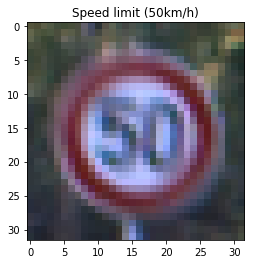

In [6]:
img = Image.fromarray(scaled_train_features[1000], 'RGB')
#img = img.resize((32, 32), Image.ANTIALIAS)
plt.imshow(train_features[1000])
plt.title(sign_class_labels[train_labels[1000]])
plt.show()

In [7]:
target_labels = set(train_labels)
print(target_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42}


### Exploring & Visualizing the dataset
Here I explore the training dataset by showing samples of different classes of the training dataset.

Class 0: Speed limit (20km/h)


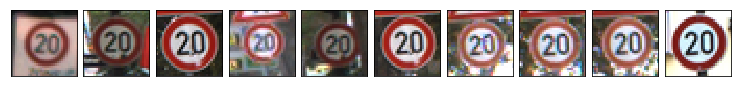

Class 5: Speed limit (80km/h)


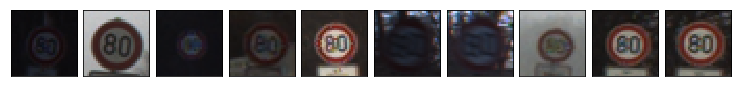

Class 10: No passing for vechiles over 3.5 metric tons


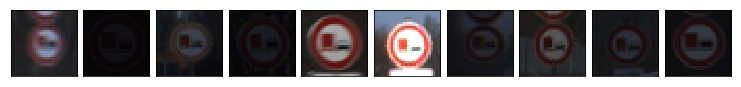

Class 15: No vechiles


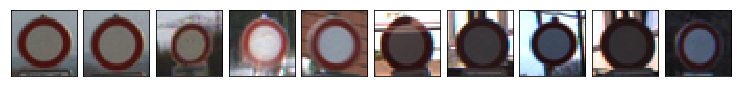

Class 20: Dangerous curve to the right


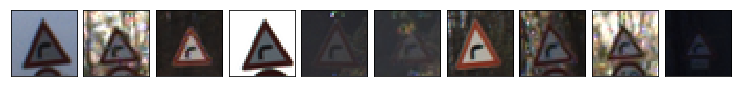

Class 25: Road work


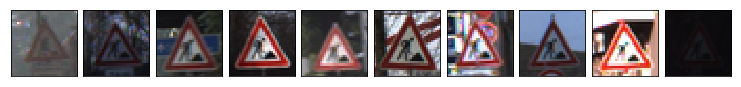

Class 30: Beware of ice/snow


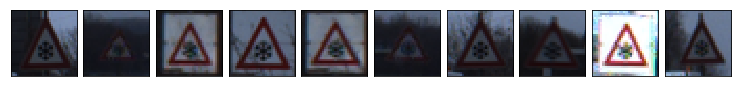

Class 35: Ahead only


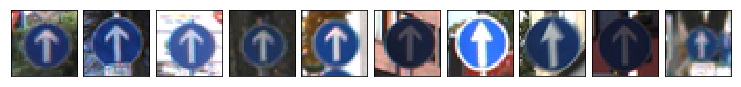

Class 40: Roundabout mandatory


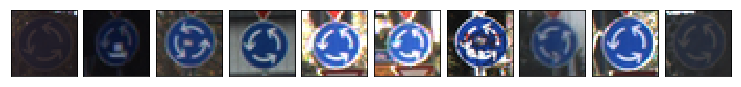

In [8]:
sign_classes, class_indices, class_counts = np.unique(initial_train_labels, return_index = True, return_counts = True)

for c, c_index, c_count in zip(sign_classes[::5], class_indices[::5], class_counts[::5]):
    print("Class %i: %s" % (c, sign_class_labels[int(c)]))
    fig = plt.figure(figsize = (10, 6))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.1, wspace = 0.1)
    random_indices = random.sample(range(c_index, c_index + c_count), 10)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        axis.imshow(initial_train_features[random_indices[i]])
    plt.show()

In the code cell below, I plot a histogram that shows the distribution of the training samples across the class labels. The X-axis is the class labels and the Y-axis is the training samples count of each class label. 

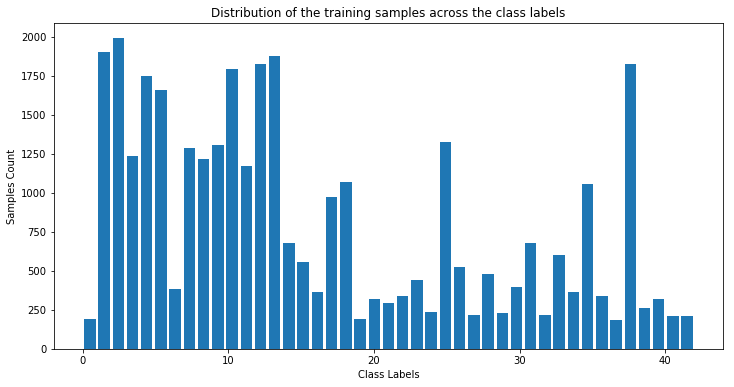

[ 188 1905 1991 1235 1750 1659  382 1289 1216 1309 1792 1172 1827 1879  678
  556  363  972 1072  188  318  291  341  440  239 1327  523  214  479  232
  395  680  218  599  367 1058  339  187 1828  262  322  209  212]


In [9]:
mu, sigma = 100, 15

hist, bins = np.histogram(train_labels, bins=43)
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

fig = plt.figure(figsize = (12, 6))

plt.title('Distribution of the training samples across the class labels')
plt.xlabel('Class Labels')
plt.ylabel('Samples Count')
plt.bar(center, hist, align='center', width=width)
plt.show()
print(hist)

<strong>In the code cell below, I provide a simple statistics about the samples assigned to each class label in the training dataset.</strong>

In [10]:
assign_label_name = lambda classId: sign_class_labels[classId]
vfunc = np.vectorize(assign_label_name)

train_labels_df = pd.DataFrame(data={'classId': train_labels, 'classLabel': vfunc(train_labels)}, 
                               columns=['classId', 'classLabel'])
sorted_train_labels_df = train_labels_df.sort_values('classId')

samples_count_per_class = sorted_train_labels_df.groupby('classId')['classLabel'].value_counts()
print('This list summarizes the statistics about the samples count per class\n\n', samples_count_per_class)

This list summarizes the statistics about the samples count per class

 classId  classLabel                                        
0        Speed limit (20km/h)                                   188
1        Speed limit (30km/h)                                  1905
2        Speed limit (50km/h)                                  1991
3        Speed limit (60km/h)                                  1235
4        Speed limit (70km/h)                                  1750
5        Speed limit (80km/h)                                  1659
6        End of speed limit (80km/h)                            382
7        Speed limit (100km/h)                                 1289
8        Speed limit (120km/h)                                 1216
9        No passing                                            1309
10       No passing for vechiles over 3.5 metric tons          1792
11       Right-of-way at the next intersection                 1172
12       Priority road                              

In the code cell below, we define two helper functions to convert the 3D tensors to 4D tensors with shape of (sample no., height, width, channels no.), these 4D tensors in that new shape will be the input later to our CNN model. The first function "convert_to_tensor" takes the numpy array of the image and returns 4D tensor for that image. The second function "prepare_tensors" iterates over all the images and convert them to their equivalent 4D tensors, then stack all the tensors verticaly in one collection of 4 tensors to be fed later into the model.

In [11]:
from keras.preprocessing import image                  
from tqdm import tqdm

def convert_to_tensor(img):
    # convert 3D tensor to 4D tensor with shape (1, 32, 32, 3) and return 4D tensor
    return np.expand_dims(img, axis=0)

def prepare_tensors(images):
    list_of_tensors = [convert_to_tensor(img) for img in tqdm(images)]
    return np.vstack(list_of_tensors)

# Helper method will be used later in the testing of the final model on a sample test images
def path_to_tensor(img_path, target_size=(32, 32)):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=target_size)
    img = img.resize((32,32), Image.ANTIALIAS)
    # convert PIL.Image.Image type to 3D tensor with shape (32, 32, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

In the code cell below, we prepare the 4D tensors of our scaled version of the training, validation, and testing data using the helper function "prepare_tensors" that we just defined above.

In [12]:
train_tensors = prepare_tensors(scaled_train_features)
valid_tensors = prepare_tensors(scaled_valid_features)
test_tensors = prepare_tensors(scaled_test_features)

100%|██████████| 12630/12630 [00:00<00:00, 353768.88it/s]


## Build the CNN model architecture

In [13]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential
from keras import regularizers

# we set the random state here to a fixed numbers to make the model reproducible
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

### This function is to define the model architecture.
def create_model(optimizer, hidden_nodes, dropout):
    model = Sequential()

    ### Define the model architecture.
    model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(hidden_nodes, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(43 , activation='softmax'))
    
    # I used "adamax" as an optimizer with "categorical_crossentropy" loss function. 
    # Adamax gave me better results for this problem compared to the other optimizers such as "adam, rmsprop, adagrad, adadelta, sgd"
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

best_model = create_model('adamax', 1024, 0.5)

best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 64)        256       
__________

In [14]:
from keras.callbacks import ModelCheckpoint , EarlyStopping 

batch_size = 64
epochs = 100

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.model.hdf5', 
                               verbose=1, save_best_only=True)

# I use early stopping callback with patience of 20 epochs to stop the training 
# if the validation loss didn't improve for 20 consecutive epochs
earlyStopping = EarlyStopping(patience=20)

model_hist = best_model.fit(train_tensors, train_targets, 
         validation_data=(valid_tensors, valid_targets),
        epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, earlyStopping], verbose=2)

Train on 34503 samples, validate on 4706 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 0.26455, saving model to saved_models/weights.best.model.hdf5
28s - loss: 0.8043 - acc: 0.7696 - val_loss: 0.2646 - val_acc: 0.9235
Epoch 2/100
Epoch 00001: val_loss improved from 0.26455 to 0.07354, saving model to saved_models/weights.best.model.hdf5
24s - loss: 0.0592 - acc: 0.9821 - val_loss: 0.0735 - val_acc: 0.9811
Epoch 3/100
Epoch 00002: val_loss improved from 0.07354 to 0.03663, saving model to saved_models/weights.best.model.hdf5
24s - loss: 0.0206 - acc: 0.9937 - val_loss: 0.0366 - val_acc: 0.9900
Epoch 4/100
Epoch 00003: val_loss did not improve
24s - loss: 0.0155 - acc: 0.9956 - val_loss: 0.0498 - val_acc: 0.9845
Epoch 5/100
Epoch 00004: val_loss improved from 0.03663 to 0.01076, saving model to saved_models/weights.best.model.hdf5
24s - loss: 0.0181 - acc: 0.9948 - val_loss: 0.0108 - val_acc: 0.9970
Epoch 6/100
Epoch 00005: val_loss did not improve
24s - loss: 0.0107 - 

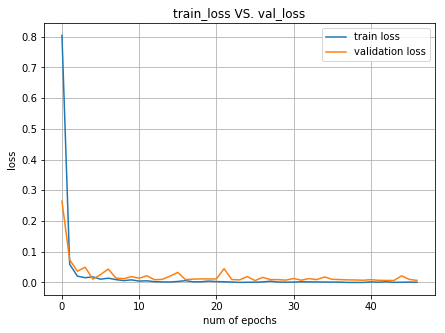

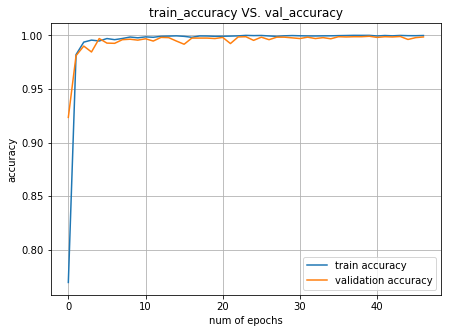

In [15]:
def plot_loss(model_hist):
    train_loss = model_hist.history['loss']
    val_loss = model_hist.history['val_loss']

    xrange = range(len(model_hist.epoch))
    plt.figure(1, figsize=(7, 5))
    plt.plot(xrange, train_loss)
    plt.plot(xrange, val_loss)
    plt.xlabel('num of epochs')
    plt.ylabel('loss')
    plt.title('train_loss VS. val_loss')
    plt.legend(['train loss', 'validation loss'])
    plt.grid(True)

def plot_accuracy(model_hist):
    train_accuracy = model_hist.history['acc']
    val_accuracy = model_hist.history['val_acc']
    
    xrange = range(len(model_hist.epoch))
    plt.figure(2, figsize=(7, 5))
    plt.plot(xrange, train_accuracy)
    plt.plot(xrange, val_accuracy)
    plt.xlabel('num of epochs')
    plt.ylabel('accuracy')
    plt.title('train_accuracy VS. val_accuracy')
    plt.legend(['train accuracy', 'validation accuracy'])
    plt.grid(True)
    
plot_loss(model_hist)
plot_accuracy(model_hist)

### Evalute the accuracy of the CNN model
In the two code cells below, we evalute the performance and the accuracy of our trained model by loading the saved weights of the model, then we use that model to predict the class labels on the test dataset, finally we calculate the test score or test accuracy by dividing the number of correctly classified images/instances (compared to the ground truth of the test targets) by the total number of instances in the test dataset.

In [16]:
best_model.load_weights('./saved_models/weights.best.model.hdf5')

In [17]:
model_predictions = [np.argmax(best_model.predict(np.expand_dims(feature, axis=0))) for feature in test_tensors]

# report test accuracy of the model
test_accuracy = 100*np.sum(np.array(model_predictions)==np.argmax(test_targets, axis=1))/len(model_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 97.7593%


## Optimize and Fine-Tune the hyper-parameters of the CNN model

Tune and optimize the hyperparameters of the model using grid search with cross validation technique.

In [14]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [17]:
# Here we use a sklearn wrapper for use in our RandomizedSearchCV class, which will 
# do a programmatic search for the best parameters for our model

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.model.cv.hdf5', 
                               verbose=1, save_best_only=True)

model_cv = KerasClassifier(build_fn=create_model,epochs=20, batch_size=64, verbose=2)

# Run through each optimizer to get the best score 
optimizer = ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']
#optimizer = ['sgd', 'rmsprop', 'adam']
hidden_nodes = [256, 512, 1024]
dropout_values = [0.2, 0.3, 0.5]

# This is our parameter grid
param_grid = dict(optimizer=optimizer, hidden_nodes=hidden_nodes, dropout=dropout_values)

grid = RandomizedSearchCV(estimator=model_cv, n_iter=1, param_distributions=param_grid, random_state=42,
                          fit_params={'callbacks': [checkpointer], 'validation_data' : (valid_tensors, valid_targets)})

grid.fit(train_tensors, train_targets)

Train on 23002 samples, validate on 4706 samples
Epoch 1/20
Epoch 00000: val_loss improved from inf to 1.55965, saving model to saved_models/weights.best.model.cv.hdf5
18s - loss: 1.4447 - acc: 0.5846 - val_loss: 1.5596 - val_acc: 0.5657
Epoch 2/20
Epoch 00001: val_loss improved from 1.55965 to 0.11143, saving model to saved_models/weights.best.model.cv.hdf5
16s - loss: 0.1408 - acc: 0.9553 - val_loss: 0.1114 - val_acc: 0.9675
Epoch 3/20
Epoch 00002: val_loss improved from 0.11143 to 0.06120, saving model to saved_models/weights.best.model.cv.hdf5
16s - loss: 0.0431 - acc: 0.9872 - val_loss: 0.0612 - val_acc: 0.9819
Epoch 4/20
Epoch 00003: val_loss did not improve
16s - loss: 0.0263 - acc: 0.9924 - val_loss: 0.1036 - val_acc: 0.9700
Epoch 5/20
Epoch 00004: val_loss improved from 0.06120 to 0.03036, saving model to saved_models/weights.best.model.cv.hdf5
16s - loss: 0.0206 - acc: 0.9943 - val_loss: 0.0304 - val_acc: 0.9913
Epoch 6/20
Epoch 00005: val_loss improved from 0.03036 to 0.0249

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f9d5c07f908>,
          fit_params={'callbacks': [<keras.callbacks.ModelCheckpoint object at 0x7f9d5c07fa20>], 'validation_data': (array([[[[ 0.41569,  0.23137,  0.16471],
         [ 0.37647,  0.21176,  0.15294],
         ...,
         [ 0.53333,  0.33725,  0.19608],
         [ 0.70588,  0.44706,  0.27451]],

        [[ 0... ...,  0.,  0.],
       ...,
       [ 0.,  1., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.]]))},
          iid=True, n_iter=1, n_jobs=1,
          param_distributions={'optimizer': ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam'], 'hidden_nodes': [256, 512, 1024], 'dropout': [0.2, 0.3, 0.5]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [18]:
# summarize results of the randomized grid search cross validation
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.996493 using {'optimizer': 'adamax', 'hidden_nodes': 1024, 'dropout': 0.5}
0.996493 (0.000296) with: {'optimizer': 'adamax', 'hidden_nodes': 1024, 'dropout': 0.5}


In [19]:
# summarize results of the randomized grid search cross validation
from pprint import pprint
pprint(grid.cv_results_)

{'mean_fit_time': array([ 342.20229785]),
 'mean_score_time': array([ 2.67651614]),
 'mean_test_score': array([ 0.99649306]),
 'mean_train_score': array([ 0.99986958]),
 'param_dropout': masked_array(data = [0.5],
             mask = [False],
       fill_value = ?)
,
 'param_hidden_nodes': masked_array(data = [1024],
             mask = [False],
       fill_value = ?)
,
 'param_optimizer': masked_array(data = ['adamax'],
             mask = [False],
       fill_value = ?)
,
 'params': ({'dropout': 0.5, 'hidden_nodes': 1024, 'optimizer': 'adamax'},),
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([ 0.99660899]),
 'split0_train_score': array([ 0.99978263]),
 'split1_test_score': array([ 0.9960873]),
 'split1_train_score': array([ 0.9998261]),
 'split2_test_score': array([ 0.99678289]),
 'split2_train_score': array([ 1.]),
 'std_fit_time': array([ 0.68421225]),
 'std_score_time': array([ 0.01992187]),
 'std_test_score': array([ 0.00029557]),
 'std_train_score': a

In [79]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator for training dataset
datagen_train = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        featurewise_center=False,
        featurewise_std_normalization=False)

# create and configure augmented image generator for validation dataset
datagen_valid = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        featurewise_center=False,
        featurewise_std_normalization=False)

# fit augmented image generator on data
datagen_train.fit(train_tensors)
datagen_valid.fit(valid_tensors)

In [53]:
# I used "adamax" as an optimizer with "categorical_crossentropy" loss function. 
# Adamax gave me better results for this problem compared to the other optimizers such as "rmsprop", "adam" and "adagrad"

#model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])

In [80]:
# We use "fit_generator" to train our model becuase we augmented the dataset in the code cell above

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.model.optimized.hdf5', 
                               verbose=1, save_best_only=True)
earlyStopping = EarlyStopping(patience=25)

epochs_num = 150
batch_size = 64

best_model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs_num, verbose=2, callbacks=[checkpointer, earlyStopping],
                    validation_data=datagen_valid.flow(valid_tensors, valid_targets, batch_size=batch_size),
                    validation_steps=valid_tensors.shape[0] // batch_size)

Epoch 1/150
Epoch 00000: val_loss improved from inf to 1.02610, saving model to saved_models/weights.best.model.optimized.hdf5
57s - loss: 1.3613 - acc: 0.5983 - val_loss: 1.0261 - val_acc: 0.6984
Epoch 2/150
Epoch 00001: val_loss improved from 1.02610 to 0.11843, saving model to saved_models/weights.best.model.optimized.hdf5
28s - loss: 0.2341 - acc: 0.9238 - val_loss: 0.1184 - val_acc: 0.9629
Epoch 3/150
Epoch 00002: val_loss did not improve
28s - loss: 0.1152 - acc: 0.9627 - val_loss: 0.1369 - val_acc: 0.9561
Epoch 4/150
Epoch 00003: val_loss improved from 0.11843 to 0.06575, saving model to saved_models/weights.best.model.optimized.hdf5
28s - loss: 0.0814 - acc: 0.9741 - val_loss: 0.0657 - val_acc: 0.9789
Epoch 5/150
Epoch 00004: val_loss did not improve
28s - loss: 0.0537 - acc: 0.9833 - val_loss: 0.0669 - val_acc: 0.9795
Epoch 6/150
Epoch 00005: val_loss improved from 0.06575 to 0.04492, saving model to saved_models/weights.best.model.optimized.hdf5
28s - loss: 0.0472 - acc: 0.98

### Evalute the accuracy of the CNN model after Data Augmentation
In the two code cells below, we evalute the performance and the accuracy of our trained model by loading the saved weights of the model after data augmentation, then we use that model to predict the class labels on the test dataset, finally we calculate the test score or test accuracy by dividing the number of correctly classified images/instances (compared to the ground truth of the test targets) by the total number of instances in the test dataset.

In [14]:
best_model.load_weights('./saved_models/weights.best.model.optimized.hdf5')

In [15]:
model_predictions = [np.argmax(best_model.predict(np.expand_dims(feature, axis=0))) for feature in test_tensors]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==np.argmax(test_targets, axis=1))/len(model_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 98.3690%


### Calculate and Plot Confusion Matrix

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools

# This function is to plot the confusion matrix of the final results on the test data
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    # Get current size
    fig_size = plt.rcParams["figure.figsize"]
 
    # Set figure width to 12 and height to 9
    fig_size[0] = 36
    fig_size[1] = 30
    plt.rcParams["figure.figsize"] = fig_size
    
    #plt(1, figsize=(36, 30))

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(test_targets, axis=1), model_predictions)

Normalized confusion matrix
[[ 1.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          1.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.00266667  0.99733333 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.01111111 ...,  0.97777778  0.          0.        ]
 [ 0.          0.          0.         ...,  0.          1.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          1.        ]]


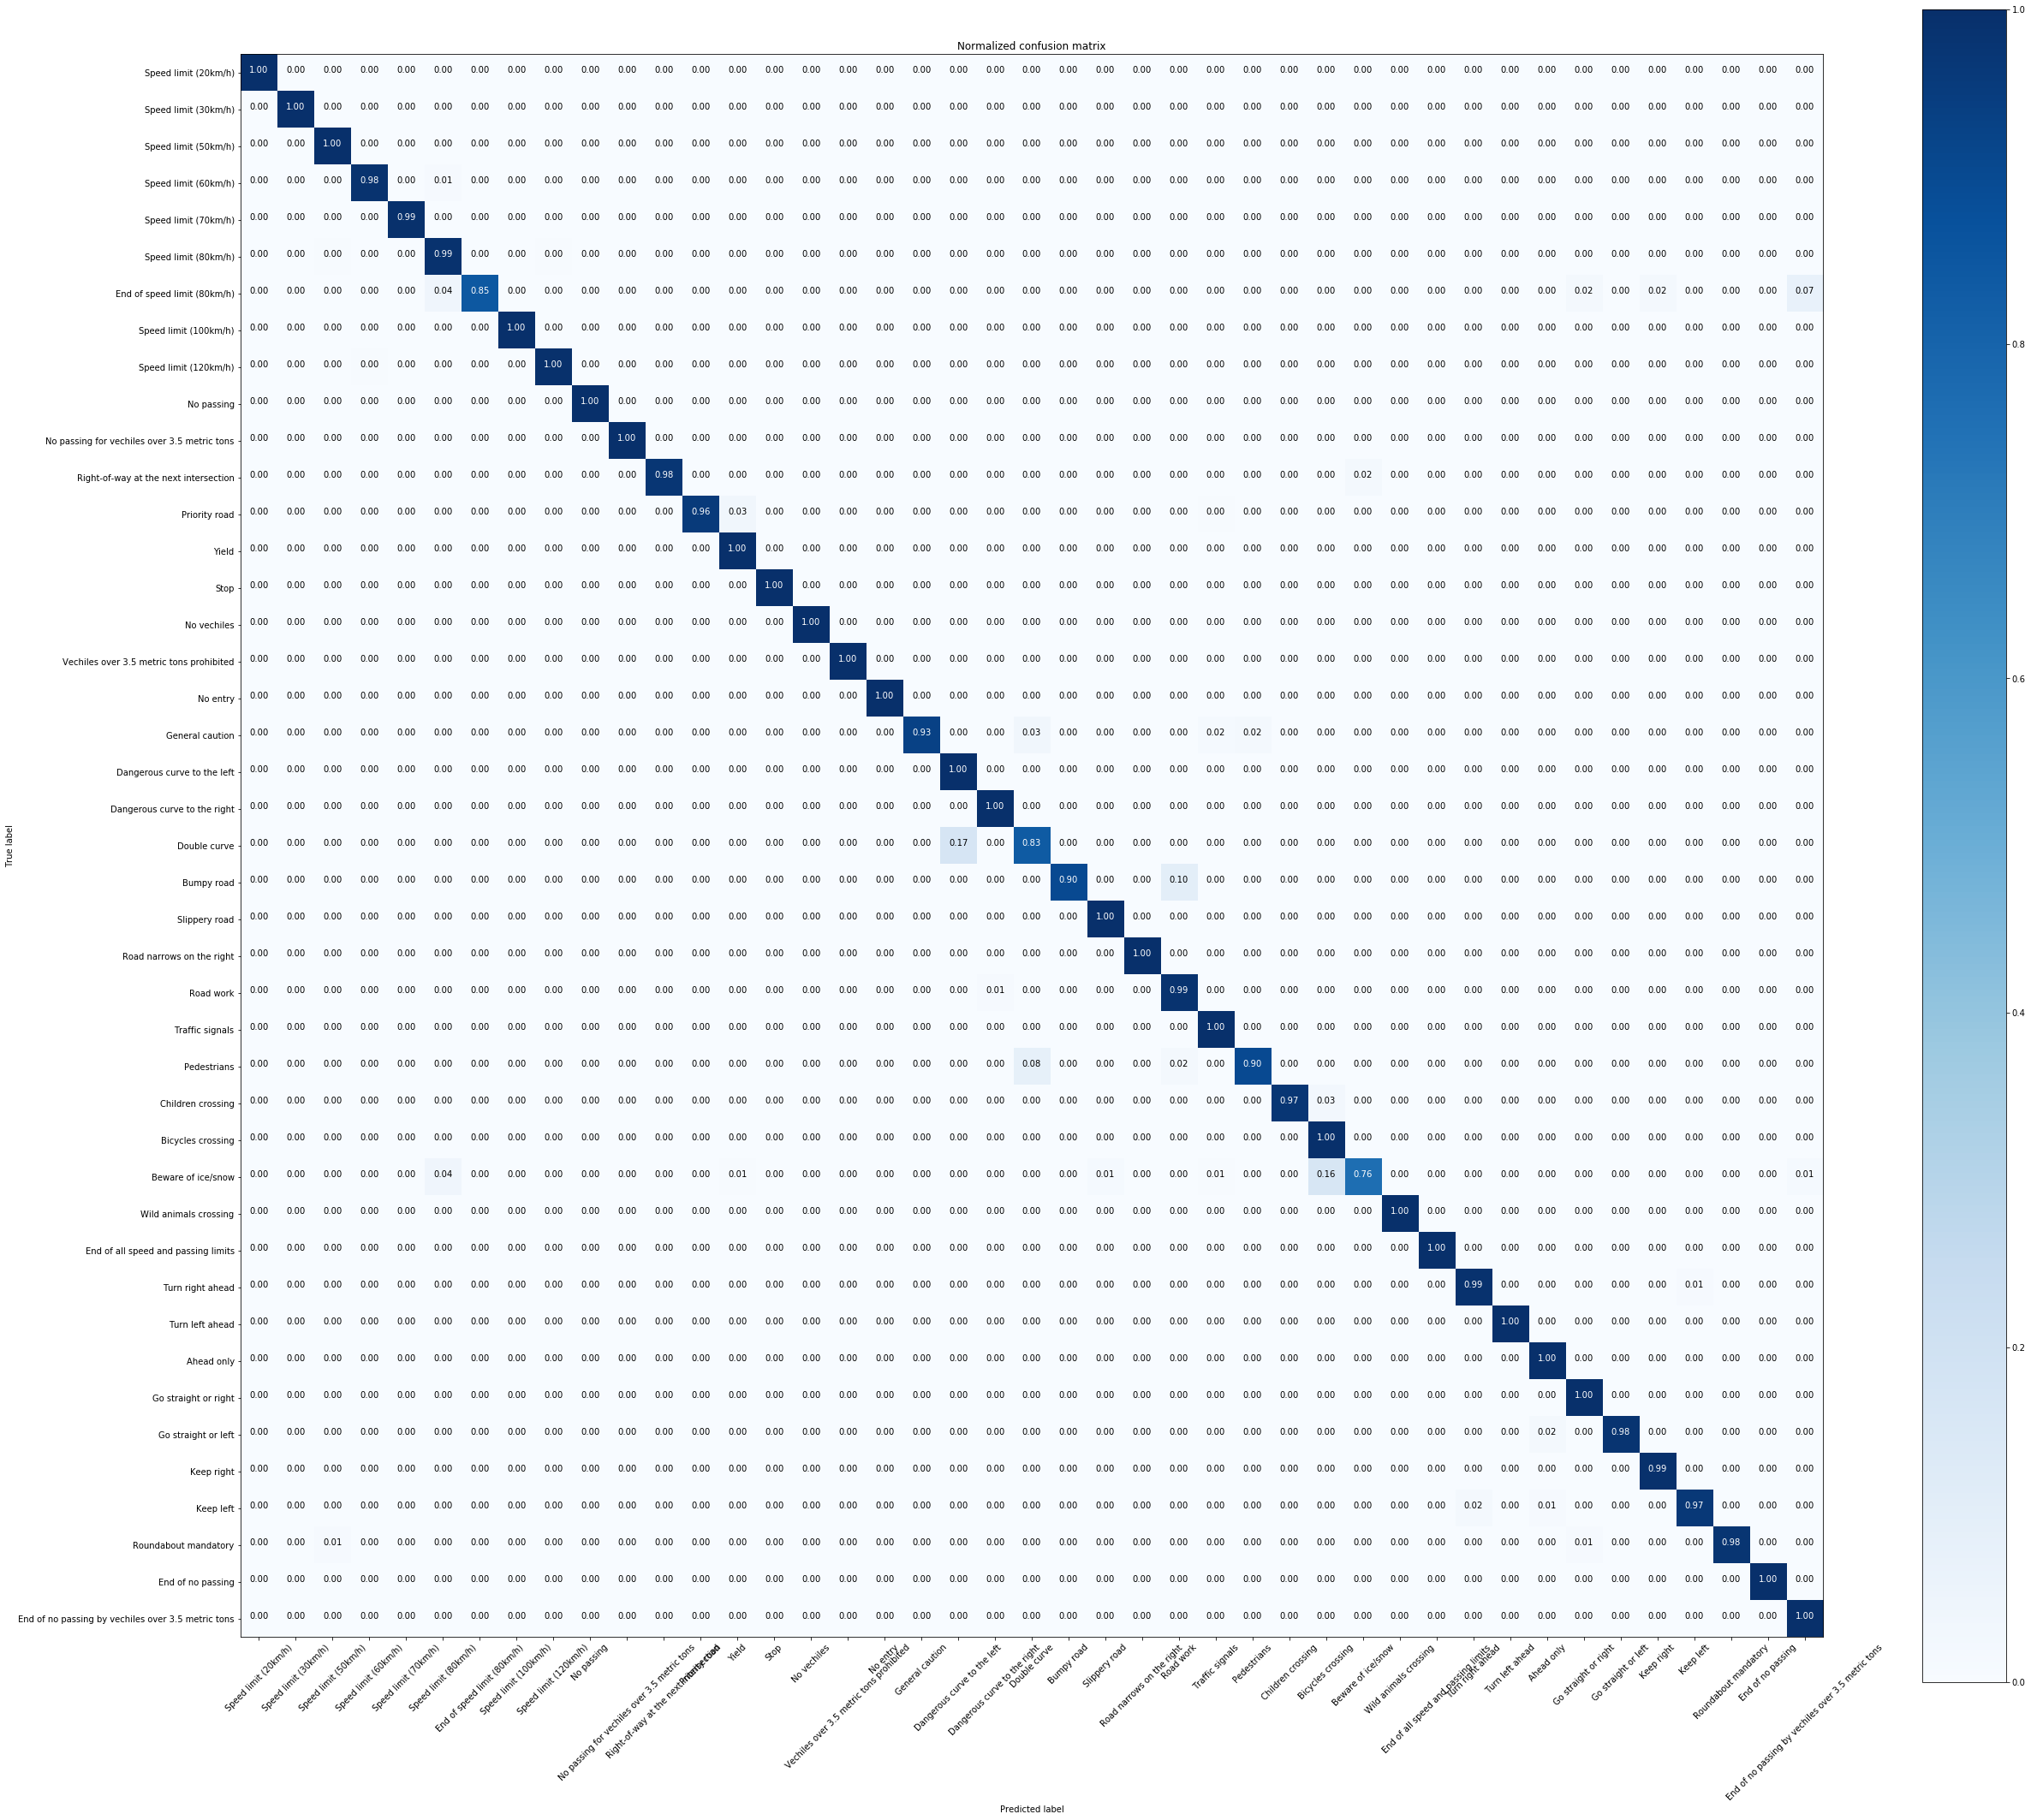

In [18]:
plot_confusion_matrix(cnf_matrix, classes=sign_class_labels, normalize=True, title='Normalized confusion matrix')

### Classification Report and Other Evaluation Metrics

In [19]:
cnf_report = classification_report(np.argmax(test_targets, axis=1), model_predictions, target_names=sign_labels_with_class_Ids)
print(cnf_report)

                                                              precision    recall  f1-score   support

                               class 0: Speed limit (20km/h)       1.00      1.00      1.00        60
                               class 1: Speed limit (30km/h)       1.00      1.00      1.00       720
                               class 2: Speed limit (50km/h)       0.99      1.00      1.00       750
                               class 3: Speed limit (60km/h)       1.00      0.98      0.99       450
                               class 4: Speed limit (70km/h)       1.00      0.99      1.00       660
                               class 5: Speed limit (80km/h)       0.97      0.99      0.98       630
                        class 6: End of speed limit (80km/h)       1.00      0.85      0.92       150
                              class 7: Speed limit (100km/h)       1.00      1.00      1.00       450
                              class 8: Speed limit (120km/h)       0.99      1.00

### Testing the final model
Here in this section, we test our final solution model after data augmentation using images that have never seen by the solution model before either in the training or the validation datasets.

In [20]:
# This function is to create the final model and then load the weights saved during the training phase
def create_final_model(weights_path):
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=1, activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=1, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(43 , activation='softmax'))

    model.load_weights(weights_path)

    return model

In [48]:
## These code cell will be run once to save the class labels of the traffic signs to npz file format as shown in below.
sign_labels_dict = {}
for item in signs_df.values:
    sign_labels_dict[item[0]] = item[1]

np.savez('traffic_sign_labels.npz', traffic_sign_labels = sign_labels_dict)

In [21]:
# This function returns the class label name of the predicted value that has the highest probability
def get_traffic_sign_label(traffic_sign_index):
    traffic_signs_labels = np.load('traffic_sign_labels.npz')
    return traffic_signs_labels.f.traffic_sign_labels.item(0)[traffic_sign_index]

# This function will beused to create the model and load the weights, then use the final model to predict 
# the class label of the given image.
def predict_traffic_sign(img_path):
    # create instance of the CNN model
    model = create_final_model(weights_path='saved_models/weights.best.model.optimized.hdf5')
    # obtain predicted vector
    predicted_vector = model.predict(path_to_tensor(img_path))
    predicted_class_label = get_traffic_sign_label(np.argmax(predicted_vector))
    # return traffic sign that is predicted by the model
    return predicted_class_label

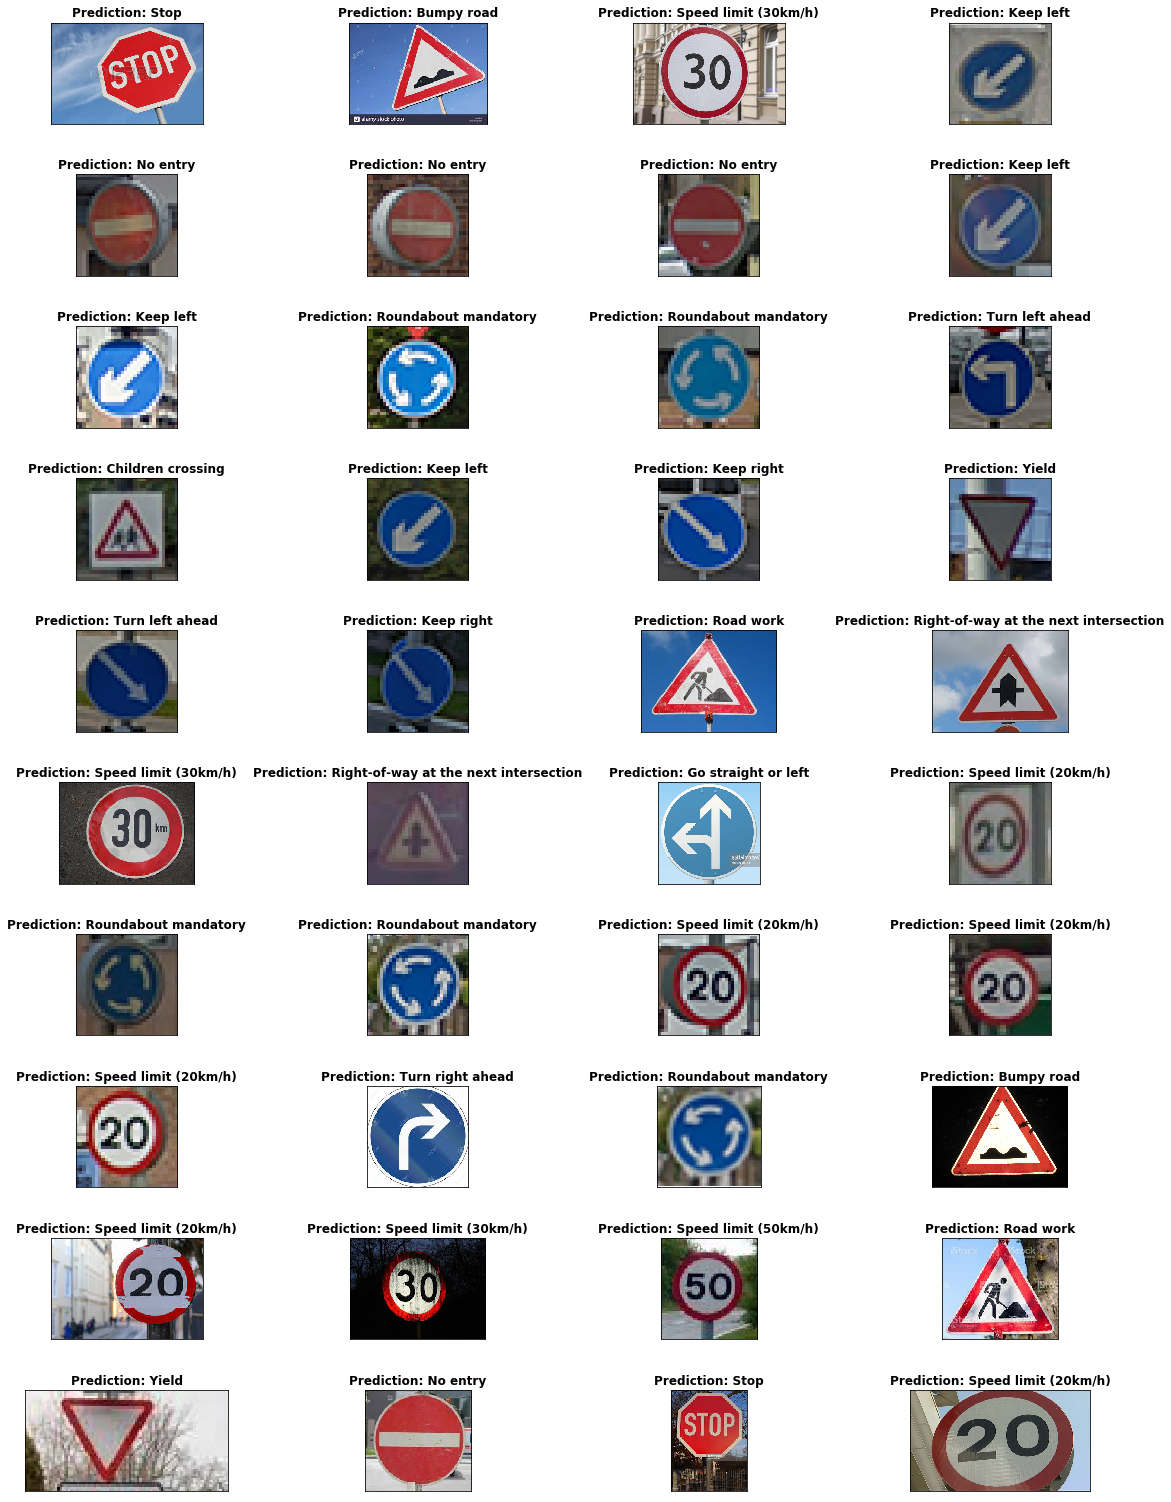

In [25]:
# Here We test out final model against the images  available in "Images_Test" folder -- already added to the submitted files

traffic_signs_test = sorted(glob("Test_Images/*"))

fig = plt.figure(figsize=(20, 30))
fig.subplots_adjust(hspace=.5, bottom = 0.2)

for i, item in enumerate(traffic_signs_test):
    predicted_sign_label = predict_traffic_sign(item)
    img = cv2.imread(item)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = cv2.resize(img, (32, 32))
    ax = fig.add_subplot(10, 4, i + 1, xticks=[], yticks=[])
    ax.set_title("Prediction: "+ predicted_sign_label, 
                 fontdict={'fontweight': 'bold'})
    ax.imshow(img)